In [7]:
import numpy as np
from common.functions import softmax
from common.other_class import Rnnlm, BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        return word_ids
    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c
    def set_state(self, state):
        self.lstm_layer.set_state(*state)

### None Training

In [9]:
import ptb

model = RnnlmGen()

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[word] for word in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '\n')
print(txt)

you doyle mundane smallest kirk seeks margins homes n't polyethylene cell kia improvements mo. grade exempt suez dec. swung torrijos concord spate keating structures crossing willingness rape principles obliged returned pumped nearly evolution effectiveness aggregates rockefeller schemes day-to-day willful cs gartner formal vaccine centers eager files czechoslovakia corporations anything joined killing triple-a quotas curbing plug jerry hazards crack cycling hutton reiterated disposal stone fleischmann exception foot conclude riders affecting gathered accumulation murdoch ddb losing owner functions fla waste climb endless longer-term crystals defendants pressured dealers d.c. invitation disabilities claimed ashland strategists arab defaulted recreational appliances unified chlorofluorocarbons venture-capital activist d'arcy


In [11]:
model.reset_state()

In [13]:
model.load_params('Rnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[word] for word in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '\n')
print(txt)

you pointed out of the dire mr. roman said
 both california one of the game is n't so low
 surprisingly oct.
 on the american home television institute issued of a moderate buy-back of shares of shares at a team of frankfurt companies
 react to suspend municipal earnings
 perhaps deferring short value or work could appear for borrowing until past particular machines or technology and does n't develop panic much or many manufacturers or control
 very good is a new company hopes that the right reason more high for the market is expected so long


In [14]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [15]:
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', 
                                                         seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

In [1]:
from common.time_layers import *
from common.base_model import BaseModel

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_w = (rn(V, D) / 100).astype('f')
        lstm_wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        
        self.embed = TimeEmbedding(embed_w)
        self.lstm = TimeLSTM(lstm_wx, lstm_wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [2]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_w = (rn(V, D) / 100).astype('f')
        lstm_wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_w = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_w)
        self.lstm = TimeLSTM(lstm_wx, lstm_wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_w, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, h):
        self.lstm.set_state(h)
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
        return sampled

In [13]:
from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

In [10]:
x_test[[1]].shape

(1, 7)

In [19]:
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
               batch_size=batch_size, max_grad=max_grad)
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, 
                                   id_to_char, verbose)
    acc = float(correct_num) / len(x_test)
    acc_list += [acc]
    print(acc*100)

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.18
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.86
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.79
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.78
| 에폭 1 |  반복 181 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.76
| 에폭 1 |  반복 221 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 7[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 8[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 9[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 9[s] | 손실 1.74
Q 77+85  
T 162 
X 101 
---
Q 975+164
T 1139
X 1001
---
Q 582+84 
T 666 
X 1001
---
Q 8+155  
T 163 
X 101 
---
Q 367+55 
T 422 
X 100 
---
Q 600+257
T 857 
X 1001
---
Q 761+292
T 1053
X 1001
---
Q 830+597
T 1427
X 1001
---
Q 26+838

6.18
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.92
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.93
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.94
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 0.93
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.93
| 에폭 9 |  반복 101 / 351 | 시간 2[s] | 손실 0.93
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 0.92
| 에폭 9 |  반복 141 / 351 | 시간 4[s] | 손실 0.95
| 에폭 9 |  반복 161 / 351 | 시간 4[s] | 손실 0.95
| 에폭 9 |  반복 181 / 351 | 시간 5[s] | 손실 0.95
| 에폭 9 |  반복 201 / 351 | 시간 5[s] | 손실 0.92
| 에폭 9 |  반복 221 / 351 | 시간 6[s] | 손실 0.90
| 에폭 9 |  반복 241 / 351 | 시간 7[s] | 손실 0.90
| 에폭 9 |  반복 261 / 351 | 시간 7[s] | 손실 0.90
| 에폭 9 |  반복 281 / 351 | 시간 8[s] | 손실 0.90
| 에폭 9 |  반복 301 / 351 | 시간 8[s] | 손실 0.91
| 에폭 9 |  반복 321 / 351 | 시간 9[s] | 손실 0.89
| 에폭 9 |  반복 341 / 351 | 시간 10[s] | 손실 0.90
Q 77+85  
T 162 
X 160 
---
Q 975+164
T 1139
X 1170
---
Q 582+84 
T 666 
X 680 
---
Q 8+155  
T 163 
X 160 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 861 
---
Q 761+292
T 1053
X 1070
---
Q 830+597
T 1427
X 1445
---
Q 

| 에폭 16 |  반복 321 / 351 | 시간 9[s] | 손실 0.68
| 에폭 16 |  반복 341 / 351 | 시간 10[s] | 손실 0.67
Q 77+85  
T 162 
X 164 
---
Q 975+164
T 1139
X 1185
---
Q 582+84 
T 666 
X 659 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
X 425 
---
Q 600+257
T 857 
X 855 
---
Q 761+292
T 1053
X 1073
---
Q 830+597
T 1427
X 1444
---
Q 26+838 
T 864 
X 865 
---
Q 143+93 
T 236 
X 237 
---
14.580000000000002
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.68
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.68
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.65
| 에폭 17 |  반복 61 / 351 | 시간 1[s] | 손실 0.66
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.66
| 에폭 17 |  반복 101 / 351 | 시간 3[s] | 손실 0.66
| 에폭 17 |  반복 121 / 351 | 시간 3[s] | 손실 0.64
| 에폭 17 |  반복 141 / 351 | 시간 4[s] | 손실 0.67
| 에폭 17 |  반복 161 / 351 | 시간 4[s] | 손실 0.69
| 에폭 17 |  반복 181 / 351 | 시간 5[s] | 손실 0.69
| 에폭 17 |  반복 201 / 351 | 시간 6[s] | 손실 0.67
| 에폭 17 |  반복 221 / 351 | 시간 6[s] | 손실 0.66
| 에폭 17 |  반복 241 / 351 | 시간 7[s] | 손실 0.64
| 에폭 17 |  반복 261 / 351 | 시간 7[s] | 손실 0.67
| 

| 에폭 24 |  반복 141 / 351 | 시간 4[s] | 손실 0.51
| 에폭 24 |  반복 161 / 351 | 시간 4[s] | 손실 0.51
| 에폭 24 |  반복 181 / 351 | 시간 5[s] | 손실 0.54
| 에폭 24 |  반복 201 / 351 | 시간 5[s] | 손실 0.52
| 에폭 24 |  반복 221 / 351 | 시간 6[s] | 손실 0.52
| 에폭 24 |  반복 241 / 351 | 시간 7[s] | 손실 0.52
| 에폭 24 |  반복 261 / 351 | 시간 7[s] | 손실 0.51
| 에폭 24 |  반복 281 / 351 | 시간 8[s] | 손실 0.50
| 에폭 24 |  반복 301 / 351 | 시간 8[s] | 손실 0.51
| 에폭 24 |  반복 321 / 351 | 시간 9[s] | 손실 0.51
| 에폭 24 |  반복 341 / 351 | 시간 10[s] | 손실 0.52
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1146
---
Q 582+84 
T 666 
X 663 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
X 420 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
X 1056
---
Q 830+597
T 1427
X 1424
---
Q 26+838 
T 864 
X 862 
---
Q 143+93 
T 236 
X 233 
---
19.96
| 에폭 25 |  반복 1 / 351 | 시간 0[s] | 손실 0.52
| 에폭 25 |  반복 21 / 351 | 시간 0[s] | 손실 0.53
| 에폭 25 |  반복 41 / 351 | 시간 1[s] | 손실 0.52
| 에폭 25 |  반복 61 / 351 | 시간 1[s] | 손실 0.53
| 에폭 25 |  반복 81 / 351 | 시간 2[s] | 손실 0.54
| 에폭 25 |  반복 1

## improve seq2seq

### Reverse, Peecky

In [14]:
from common.time_layers import *
import numpy as np

class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None
    
    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape
        
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)
        
        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)
        
        score = self.affine.forward(out)
        self.cache = H
        return score
    
    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


In [15]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 5[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 8[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 9[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 11[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 13[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 14[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 16[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 17[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 18[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 20[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 21[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 22[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1023
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1111
--

| 에폭 8 |  반복 321 / 351 | 시간 25[s] | 손실 0.35
| 에폭 8 |  반복 341 / 351 | 시간 27[s] | 손실 0.34
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 657 
---
Q 8+155  
T 163 
X 155 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1438
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 65.040%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 3[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 4[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 6[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 8[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 9[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 11[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 13[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 14[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 16[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 18[s] | 손실 0.25
| 에폭 9 |  반복 241 / 351 | 시간 19[s] | 손실 0.24
| 에폭 9 |  반복 261 / 351 | 시간 21[s] | 손실 0.24
| 에폭 9 |  반복 2

| 에폭 16 |  반복 101 / 351 | 시간 8[s] | 손실 0.04
| 에폭 16 |  반복 121 / 351 | 시간 9[s] | 손실 0.04
| 에폭 16 |  반복 141 / 351 | 시간 11[s] | 손실 0.04
| 에폭 16 |  반복 161 / 351 | 시간 13[s] | 손실 0.03
| 에폭 16 |  반복 181 / 351 | 시간 14[s] | 손실 0.04
| 에폭 16 |  반복 201 / 351 | 시간 16[s] | 손실 0.03
| 에폭 16 |  반복 221 / 351 | 시간 17[s] | 손실 0.03
| 에폭 16 |  반복 241 / 351 | 시간 19[s] | 손실 0.03
| 에폭 16 |  반복 261 / 351 | 시간 21[s] | 손실 0.03
| 에폭 16 |  반복 281 / 351 | 시간 22[s] | 손실 0.03
| 에폭 16 |  반복 301 / 351 | 시간 24[s] | 손실 0.03
| 에폭 16 |  반복 321 / 351 | 시간 25[s] | 손실 0.03
| 에폭 16 |  반복 341 / 351 | 시간 27[s] | 손실 0.04
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 97.180%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.03
| 에폭 17 |  반복 41 / 351 | 시간 3[s] | 손실

Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 98.460%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 41 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 61 / 351 | 시간 5[s] | 손실 0.01
| 에폭 24 |  반복 81 / 351 | 시간 6[s] | 손실 0.02
| 에폭 24 |  반복 101 / 351 | 시간 7[s] | 손실 0.01
| 에폭 24 |  반복 121 / 351 | 시간 9[s] | 손실 0.02
| 에폭 24 |  반복 141 / 351 | 시간 11[s] | 손실 0.04
| 에폭 24 |  반복 161 / 351 | 시간 12[s] | 손실 0.05
| 에폭 24 |  반복 181 / 351 | 시간 14[s] | 손실 0.06
| 에폭 24 |  반복 201 / 351 | 시간 15[s] | 손실 0.05
| 에폭 24 |  반복 221 / 351 | 시간 17[s] | 손실 0.03
| 에폭 24 |  반복 241 / 351 | 시간 18[s] | 손실 0.03
| 에폭 24 |  반복 261 / 351 | 시간 20[s] | 손실 0.04
| 에폭 24 |  반복 281 / 351 | 시간 21[s] | 손실 0.03
| 에폭 24 |  반복 301 / 351 | 시간 23[s] | 손실 0.0

C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sinjy\

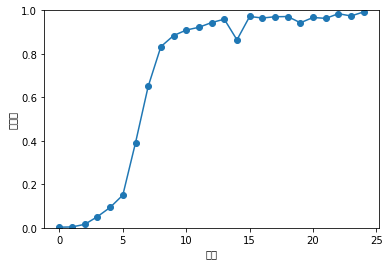

In [17]:
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1] # reverse

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()